In [1]:
# Homework 5 (due 07/30/2024)

# SVM and Kernels

### Objective
Through this project, you will learn to use nonlinear kernels to improve a support vector classifier. The toy examples within this project aim to guide you as you build your intuition for the decision boundaries that can be generated via different kernels.

This project is structured as follows:
#### Part 1: Binary classification of synthetic data
1.1. Generate and explore synthetic data

1.2. SVM with nonlinear kernels
#### Part 2: US Flags
2.1. Load and explore flags data

2.2. SVMs for flag pixel data

2.3. Comparison to decision trees


In [2]:
# standard imports
import os, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# sklearn imports
from sklearn.datasets import *
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay

# you may need to install the PIL in your environment
# for installation in mamba environment type "mamba install pillow -c conda-forge" in your miniforge prompt
# for installation in conda environment type "conda install pillow -c conda-forge" in your conda prompt or anaconda prompt
# for installation via pip type "pip install pillow" in your terminal
from PIL import Image

## Part 1: Binary classification of synthetic data

### Part 1.1: Generate and explore synthetic data
The next cell defines the function `generate_dataset`, which you can use to generate synthetic (i.e., computer generated) data sets for binary classification. It includes eight different methods for data-set generation. 
1. Try out each method and visualize the resulting data set. For the 'swiss' and 'scurve' data sets, try out two different values of the keyword argument `splits`.
2. Comment on WHETHER and WHY you anticipate this data set to be relatively easy or relatively hard to classify with a linear classifier.
3. Comment on WHETHER and WHY you anticipate this data set to be relatively easy or relatively hard to classify with a nonlinear classifier.

In [3]:
# Function to convert an array of real numbers into an array of 0s and 1s
def binarize(arr, split=10):
    # Calculate the decile thresholds
    percentiles = int(np.ceil(100/split))
    split_points = np.arange(0, 100+percentiles, percentiles)
    split_points[split_points>100] = 100
    deciles = np.percentile(arr, split_points)
    
    # Create a new array to hold the modified values
    modified_arr = np.zeros_like(arr)
    
    # Iterate through each decile range and set values accordingly
    for i in range(split):
        print(i)
        if i == split-1:
            if i % 2 == 0:
                # Set values in even deciles to 0
                modified_arr[(arr >= deciles[i])] = 0
            else:
                # Set values in odd deciles to 1
                modified_arr[(arr >= deciles[i])] = 1
        else:        
            if i % 2 == 0:
                # Set values in even deciles to 0
                modified_arr[(arr >= deciles[i]) & (arr < deciles[i + 1])] = 0
            else:
                # Set values in odd deciles to 1
                modified_arr[(arr >= deciles[i]) & (arr < deciles[i + 1])] = 1
    
    return modified_arr

# Function to generate datasets
def generate_dataset(dataset_type, n_samples=300, noise=0.1, split=10, random_state=0):
    if dataset_type == 'linearly_separable':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2,
                                   random_state=random_state, n_clusters_per_class=1)
    elif dataset_type == 'blobs':
        X, y = make_blobs(n_samples=[n_samples//2, n_samples//2], random_state=random_state, cluster_std=noise)
    elif dataset_type == 'quantiles':
        X, y = make_gaussian_quantiles(n_samples=n_samples, n_classes=2, cov=noise, random_state=random_state)
    elif dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    elif dataset_type == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5, random_state=random_state)
    elif dataset_type == 'unstructured':
        X, y = np.random.random(size=(n_samples, 2)), np.random.randint(0,2, size=(n_samples))
    elif dataset_type == 'swiss':
        X, y = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=random_state)
        X=np.array([X[:,0],X[:,2]]).T
        y = binarize(y, split=split)
    elif dataset_type == 'scurve':
        X, y = make_s_curve(n_samples=n_samples, noise=noise, random_state=random_state)
        X=np.array([X[:,0],X[:,2]]).T
        y = binarize(y, split=split)
    else:
        raise ValueError("Invalid dataset type")
    
    X = StandardScaler().fit_transform(X)
    return X, y

In [4]:
def visualize(data):
    x_coords, y_coords = zip(*data[0])
    plt.scatter(x_coords, y_coords, c=data[1], cmap='bwr', edgecolor='k')
    plt.show()

For all of the following data sets, it should be noted that if a linear classifier has high accuracy, it follows that a nonlinear classifier should have high accuracy as well as a more complex model can just follow a similar shape as the linear boundary. 

Another note is that a nonlinear classifier with infinite complexity could be overfitted on any data set to yield 100% training accuracy.

In [5]:
data_sets = {}

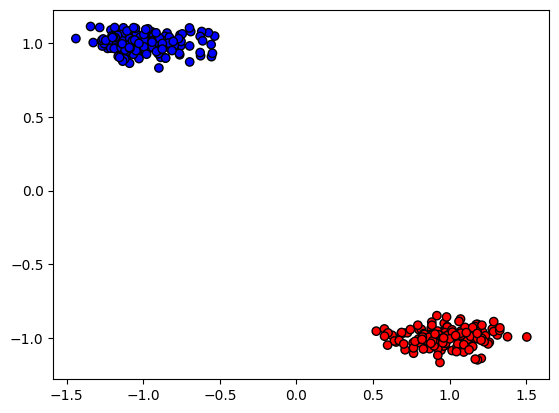

In [6]:
# Generate and visualize data blobs
'''ADD SOME CODE HERE'''
blobs = generate_dataset('blobs')
visualize(blobs)

data_sets["blobs"] = blobs

This data should be easily classified by both linear and nonlinear classifiers because the two sets are very clearly separated and any divider will have no issue dividing them.

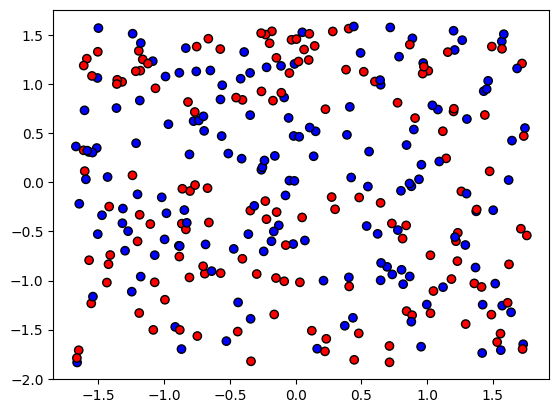

In [7]:
# Generate and visualize unstructured data
'''ADD SOME CODE HERE'''
unstructured = generate_dataset('unstructured')
visualize(unstructured)

data_sets["unstructured"] = unstructured

This data should be difficult to classify for both linear and nonlinear classifiers because the two sets come from the same distribution so there is no classifier that can accurately discriminate the two.

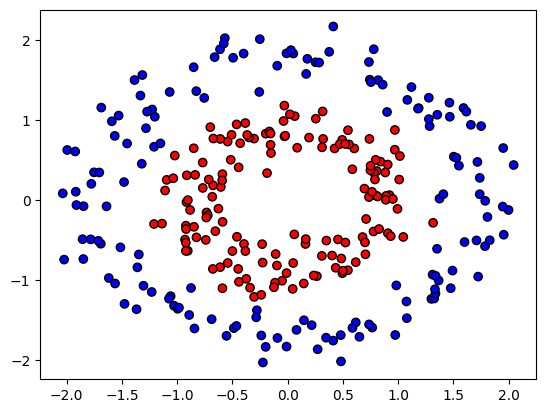

In [8]:
# Generate and visualize circles data set
'''ADD SOME CODE HERE'''
circles = generate_dataset('circles')
visualize(circles)

data_sets["circles"] = circles

This data should be difficult for linear classifiers because the dividing boundary is a circle which cannot be accurately represented by a line. Meanwhile, a nonlinear circular boundary (perhaps generated by a radial basis function) should be able to completely separate the two.

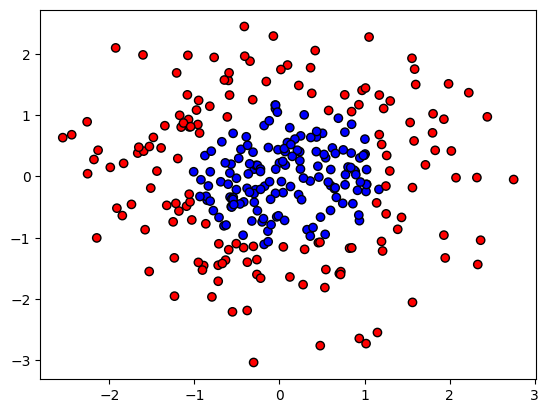

In [9]:
# Generate and visualize Gaussian quantiles
'''ADD SOME CODE HERE'''
quantiles = generate_dataset('quantiles')
visualize(quantiles)

data_sets["quantiles"] = quantiles

As was the case with the circles, a linear classifier should have difficulty since the boundary is circular, while a nonlinear classifier should be able to divide the sets very accurately.

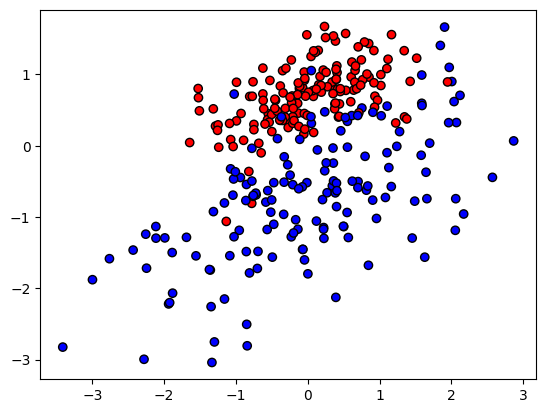

In [10]:
# Generate and visualize linearly separable data
'''ADD SOME CODE HERE'''
linearly_separable = generate_dataset('linearly_separable')
visualize(linearly_separable)

data_sets["linearly_separable"] = linearly_separable

There is some overlap between the two sets, but for the most part, a linear classifier should yield high accuracy since there is a slight linear divide between the two. Since a linear classifier will likely yield high accuracy, a nonlinear classifier will likely also yield high accuracy.

A nonlinear boundary of not too high complexity will likely be of similar shape as the lienar classifier and a nonlinear boundary of very high complexity will likely attempt to trace out the line of the divide between the sets but will ultimately, the boundary will likely be mostly linear.

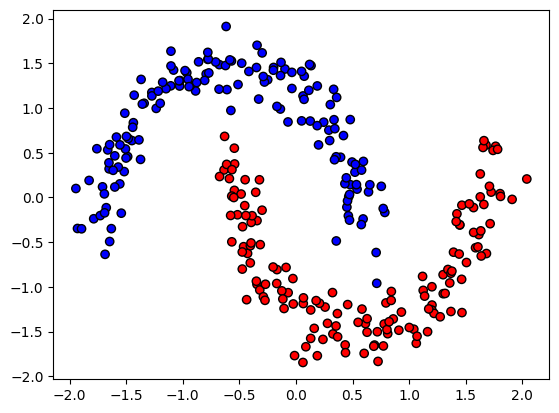

In [11]:
# Generate and visualize moons data set
'''ADD SOME CODE HERE'''
moons = generate_dataset('moons')
visualize(moons)

data_sets["moons"] = moons

A linear classifier will likely not yield extremely high accuracy as there is no linear divide that can capture all of the separation between the two sets. However, the sets are mostly separated and there is likely at least one line that can separate most of the data.

On the other hand, the sets are compeletely mutually exclusive so a nonlinear classifier will likely have extremely high accuracy, especially if it is given enough complexity.

0
1


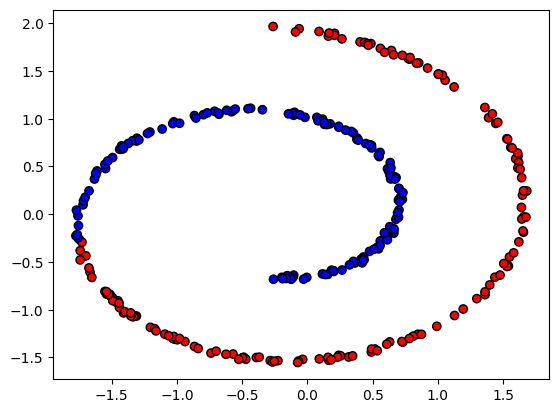

In [12]:
# Generate and visualize swiss role with 2 split sets
'''ADD SOME CODE HERE'''
swiss_2 = generate_dataset('swiss', split=2)
visualize(swiss_2)

data_sets["swiss_2"] = swiss_2

A linear separator is likely to fail to capture a lot of divide between the two sets because the tail red portion wraps around in such a way that a linear separator will likely cross through it, misclassifying a large portion of it.

Meanwhile, a nonlinear separator will likely have high accuracy since there are many boundaries that completely capture the blue portion while excluding the red. For instance, even a simple ellipse can be drawn that should yield 100% training accuracy.

0
1


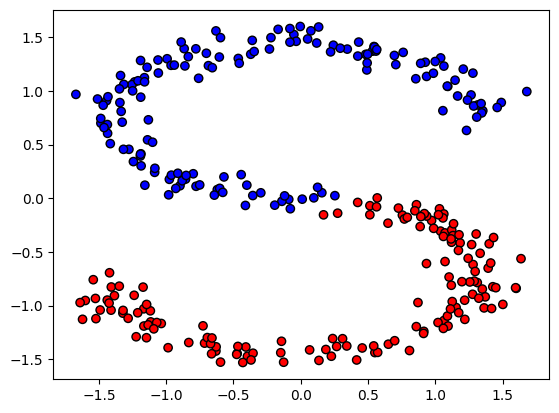

In [13]:
# Generate and visualize S curve with 2 split sets
'''ADD SOME CODE HERE'''
scurve_2 = generate_dataset('scurve',split=2)
visualize(scurve_2)

data_sets["scurve_2"] = scurve_2

There is a linear separator that can likely separate the two sets very cleanly. The diagonal line spanning from about (-1.5, -0.5) to (1.5, 0.5) separates the two sets well which yield high accuracy. This also means a nonlinear separator will likely yield high accuracy too. A nonlinear classifier could resemble the linear separator, but it could be different shapes like a simple ellipse that encircles one of the sets.

0
1
2
3
4
5
6
7
8
9


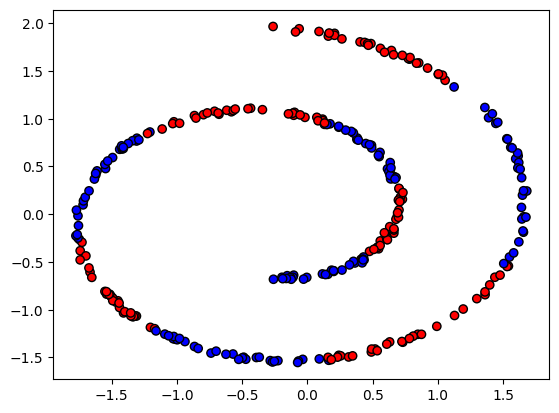

In [14]:
# Generate and visualize swiss role with 10 split sets
'''ADD SOME CODE HERE'''
swiss_10 = generate_dataset('swiss', split=10)
visualize(swiss_10)

data_sets["swiss_10"] = swiss_10

With more splits, the linear classifier just performs even worse as there is no clear line to divide the sets. Meanwhile, a simple nonlinear classifier will likely yield poor accuracy since a nonlinear boundary has many different separations that it has to cover. However, a highly complex nonlinear classifier can yield high accuracy since the sets are compeltely separated and there could be a boundary that separates the sets.

0
1
2
3
4
5
6
7
8
9


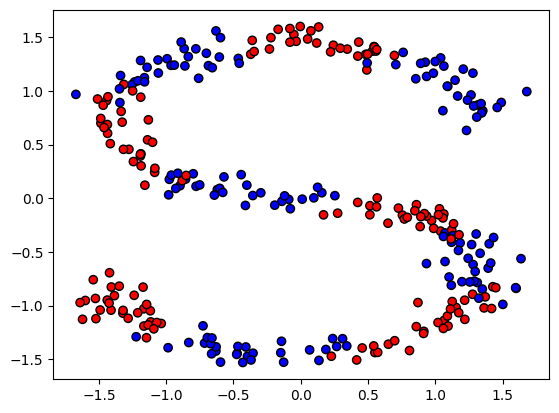

In [15]:
# Generate and visualize S curve with 10 split sets
'''ADD SOME CODE HERE'''
scurve_10 = generate_dataset('scurve', split=10)
visualize(scurve_10)

data_sets["scurve_10"] = scurve_10

Although the 2 split scurve could be separated by a linear classifier, this more complex scurve cannot be easily classified and will certainly yield poor results. Similarly, a simple nonlinear classifier will likely struggle too since there are many different boundaries to consider. However, a more complex nonlinear classifier can yield high accuracies since the boundaries are clearly defined and a different basis may be able to capture the separation.

### Part 1.2: SVM with nonlinear kernels

The next cell defines the function `kernel_comparison`, which you can use to visually compare the decision boundaries generated by SVMs with different kernels. 

1. The kernel comparison currently produces only visual results. Add code to the function so that it also outputs train and test accuracy of the different SVMs. (Note: Think carefully about where the right place in the code is to do a train-test split.)
2. Run the kernel comparison for the data sets from Part 1.1. Do the results confirm or contradict your expectations that you formulated in Part 1.1.? Did any of the results surprise you?
3. Consult sklearn's documentation to learn how the keyword arguments `degree` and `gamma` affect your classifier. Try out a few different values of these parameters. How and what can one infer from the shape of the decision boundary about the classifier's `degree` or `gamma`?

In [16]:
def kernel_comparison(X, y, set = "", support_vectors=True, tight_box=False, if_flag=False, degree = 3, gamma = 3, accuracy = True, visualize = True):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)

    accuracies = {}
    
    if(visualize):
        fig = plt.figure(figsize=(10,3))
    
    for ikernel, kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
        # Train the SVC
        clf = SVC(kernel=kernel, degree=degree, gamma=gamma).fit(X_train, y_train)
        
        train_accuracy = round(clf.score(X_train, y_train),2)
        test_accuracy = round(clf.score(X_test, y_test),2)
        accuracies[kernel] = (train_accuracy, test_accuracy)
        
        if(visualize):
        
            # Settings for plotting
            if(if_flag):
                ax = plt.subplot(2,2,1+ikernel)
            else:
                ax = plt.subplot(1,4,1+ikernel)
            #x_min, x_max, y_min, y_max = -3, 3, -3, 3
            #ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

            # Plot decision boundary and margins
            common_params = {"estimator": clf, "X": X, "ax": ax}
            DecisionBoundaryDisplay.from_estimator(
                **common_params,
                response_method="predict",
                plot_method="pcolormesh",
                alpha=0.3,
            )
            DecisionBoundaryDisplay.from_estimator(
                **common_params,
                response_method="decision_function",
                plot_method="contour",
                levels=[-1, 0, 1],
                colors=["k", "k", "k"],
                linestyles=["--", "-", "--"],
            )

            if support_vectors:
                # Plot bigger circles around samples that serve as support vectors
                ax.scatter(
                    clf.support_vectors_[:, 0],
                    clf.support_vectors_[:, 1],
                    s=150,
                    facecolors="none",
                    edgecolors="k",
                )

            # Plot samples by color and add legend
            ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
            if(accuracy):
                if(if_flag and ikernel > 1):
                    ax.text(0.5, -0.55, kernel + "\nTraining accuracy: " + str(train_accuracy) + "\nTesting accuracy: " + str(test_accuracy),
                            transform=ax.transAxes, ha='center', fontsize=12)
                else:
                    ax.set_title(kernel + "\nTraining accuracy: " + str(train_accuracy) + "\nTesting accuracy: " + str(test_accuracy))
            else:
                ax.set_title(kernel)
            ax.axis('off')
            if tight_box:
                ax.set_xlim([X[:, 0].min(), X[:, 0].max()])
                ax.set_ylim([X[:, 1].min(), X[:, 1].max()])
        
        '''ADD SOME CODE HERE'''
    if(visualize):
        fig.suptitle(set, fontsize=16)
        if(if_flag):
            plt.subplots_adjust(top=0.85)
        else:
            plt.subplots_adjust(top=0.75)
    if(accuracy):
        return accuracies

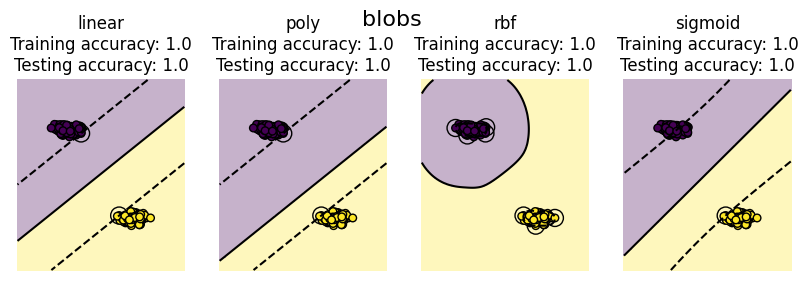

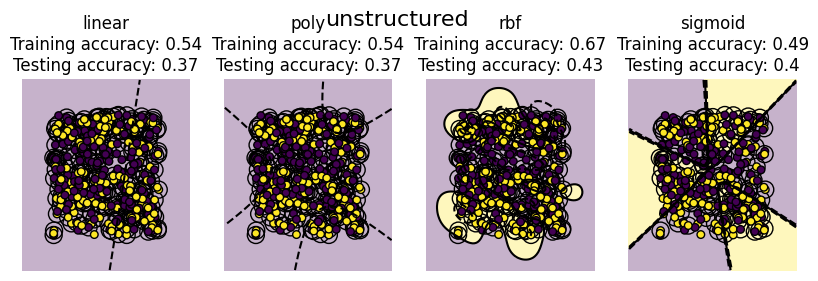

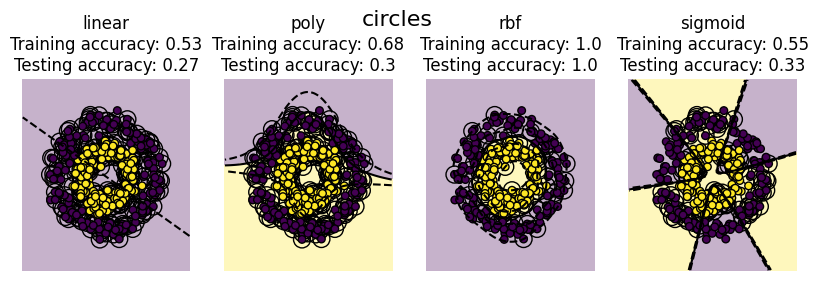

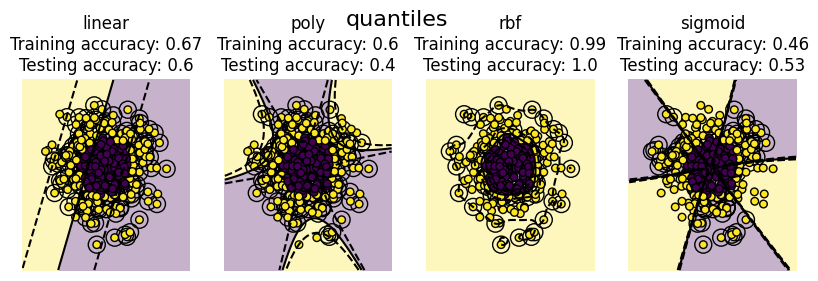

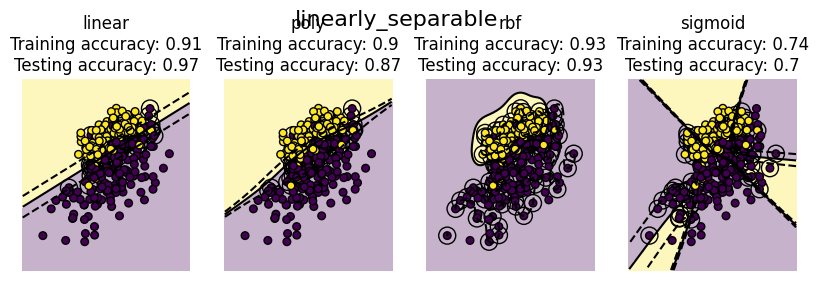

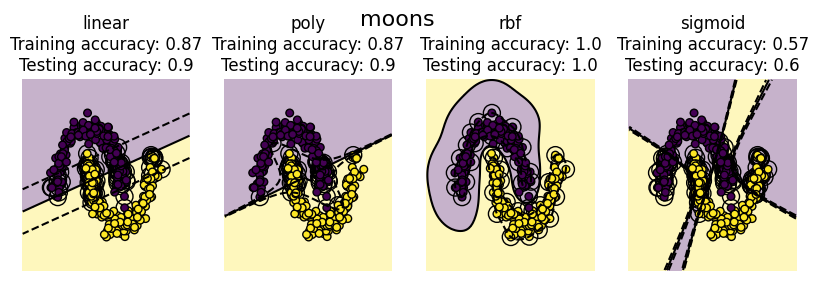

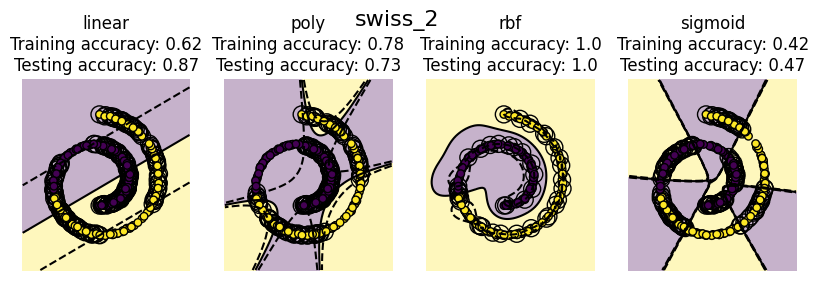

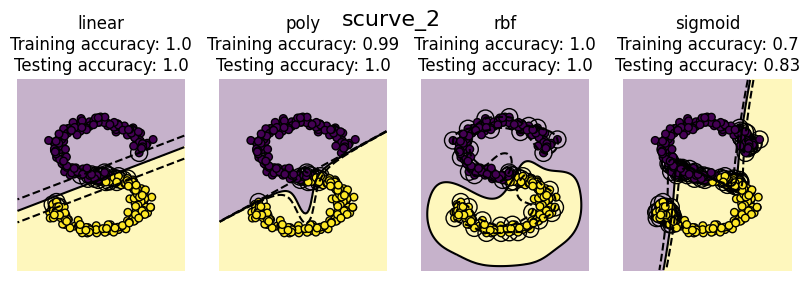

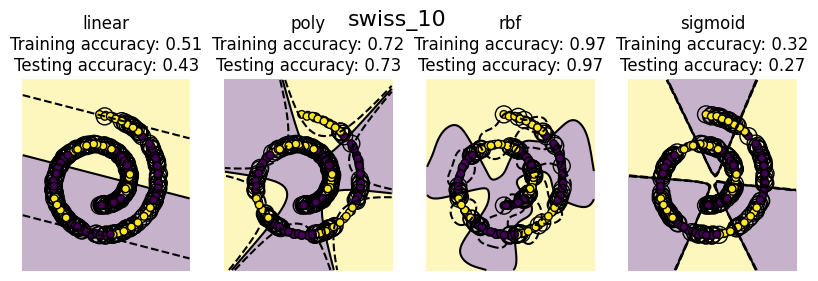

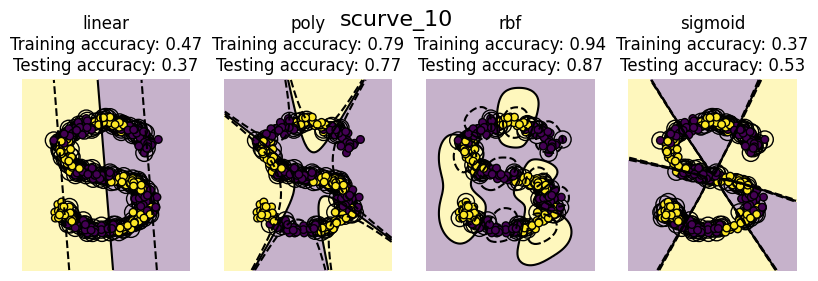

In [17]:
# Show results of kernel comparison for data sets from part 1
'''ADD SOME CODE HERE'''
accuracies = {}
for set in data_sets.keys():
    accuracies[set] = (kernel_comparison(data_sets[set][0], data_sets[set][1], set))

Most of the boundaries are about what I expected with the linear classifiers doing relatively well in simple distributions, but struggling on more complex shapes. I was surprised that the linear classifier had such a linear accuracy on the moons data set (0.87 training, 0.9 testing).

Among the nonlinear classifiers, the rbf model consistently performed the best, which makes sense as it had the most complexity and could therefore draw boundaries very closely. This is evidenced by the rbf getting a training score of 0.67 on the unstructured data even when both of the sets come from the same distribution so there should be no accurate boundary, leading to a 50% completely random accuracy.

It was surprising that for many of the distributions, the testing accuracy was higher than the training, but this is likely a result of the testing sample being relatively small (30 samples).

Another surprise was that in some cases, the training accuracy was below 50%. This confused me as if the model had a below 50% training accuracy, couldn't the model just keep the same boundaries but flip the final classification to turn a below 50% accuracy into an above 50% accuracy?

In [18]:
flattened_data = []
for dataset, models in accuracies.items():
    for model, accuracies in models.items():
        training_acc, testing_acc = accuracies
        flattened_data.append((dataset, model, training_acc, testing_acc))

# Create a DataFrame from the flattened data
df = pd.DataFrame(flattened_data, columns=['Dataset', 'Model', 'Training Accuracy', 'Testing Accuracy'])

df

Dataset    Model  Training Accuracy  Testing Accuracy
0                blobs   linear               1.00              1.00
1                blobs     poly               1.00              1.00
2                blobs      rbf               1.00              1.00
3                blobs  sigmoid               1.00              1.00
4         unstructured   linear               0.54              0.37
5         unstructured     poly               0.54              0.37
6         unstructured      rbf               0.67              0.43
7         unstructured  sigmoid               0.49              0.40
8              circles   linear               0.53              0.27
9              circles     poly               0.68              0.30
10             circles      rbf               1.00              1.00
11             circles  sigmoid               0.55              0.33
12           quantiles   linear               0.67              0.60
13           quantiles     poly               0.60              0.40
14           quantiles      rbf               0.99              1.00
15           quantiles  sigmoid               0.46              0.53
16  linearly_separable   linear               0.91              0.97
17  linearly_separable     poly               0.90              0.87
18  linearly_separable      rbf               0.93              0.93
19  linearly_separable  sigmoid               0.74              0.70
20               moons   linear               0.87              0.90
21               moons     poly               0.87              0.90
22               moons      rbf               1.00              1.00
23               moons  sigmoid               0.57              0.60
24             swiss_2   linear               0.62              0.87
25             swiss_2     poly               0.78              0.73
26             swiss_2      rbf               1.00              1.00
27             swiss_2  sigmoid               0.42              0.47
28            scurve_2   linear               1.00              1.00
29            scurve_2     poly               0.99              1.00
30            scurve_2      rbf               1.00              1.00
31            scurve_2  sigmoid               0.70              0.83
32            swiss_10   linear               0.51              0.43
33            swiss_10     poly               0.72              0.73
34            swiss_10      rbf               0.97              0.97
35            swiss_10  sigmoid               0.32              0.27
36           scurve_10   linear               0.47              0.37
37           scurve_10     poly               0.79              0.77
38           scurve_10      rbf               0.94              0.87
39           scurve_10  sigmoid               0.37              0.53

In [19]:
model_means = df[['Model', 'Training Accuracy', 'Testing Accuracy']].groupby('Model').mean()
dataset_means = df[['Dataset', 'Training Accuracy', 'Testing Accuracy']].groupby('Dataset').mean()

In [20]:
model_means

Training Accuracy  Testing Accuracy
Model                                       
linear               0.712             0.678
poly                 0.787             0.707
rbf                  0.950             0.920
sigmoid              0.562             0.566

We can see that the rbf models had, on average, the highest training and testing accuracy by a relatively large margin. The sigmoid models had, on average, the worst accuracies, barely above 0.5, which would be equivalent to random guessing with no boundary classifier.

The linear and polynomial models had okay accuracy. They didn't perform too well, but given the linear and polynomial models' simplicity, it is surprising how well it held up.

In [21]:
dataset_means

Training Accuracy  Testing Accuracy
Dataset                                                
blobs                          1.0000            1.0000
circles                        0.6900            0.4750
linearly_separable             0.8700            0.8675
moons                          0.8275            0.8500
quantiles                      0.6800            0.6325
scurve_10                      0.6425            0.6350
scurve_2                       0.9225            0.9575
swiss_10                       0.6300            0.6000
swiss_2                        0.7050            0.7675
unstructured                   0.5600            0.3925

We can see that the data sets that had mutually exclusive sets (such as blobs, scurve_2, moons, etc.) tended to have better classification than those with mixed sets (such as swiss_2, circles, quantiles, etc.). This makes sense as obviously, those with clear divisive boundaries will be easier to classify than those that are overlapped.

{'linear': (0.87, 0.9),
 'poly': (0.93, 0.9),
 'rbf': (1.0, 1.0),
 'sigmoid': (0.71, 0.6)}

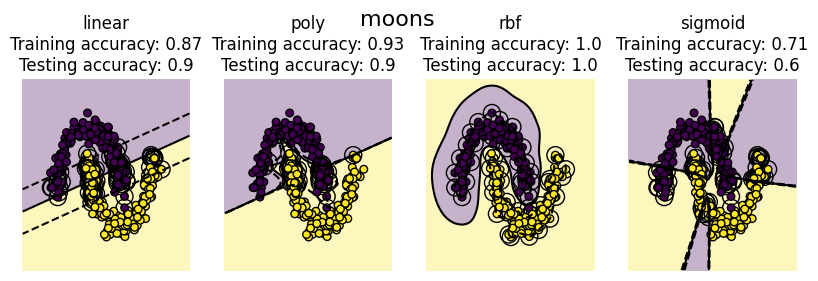

In [22]:
# Examine effect of degree and gamma keyword
'''ADD SOME CODE HERE'''
kernel_comparison(moons[0], moons[1], 'moons', degree = 5, gamma = 5)

The `degree` argument affects the polynomial model. It changes the model by making the degree of the polynomial higher, allowing for a more complex and curvy boundary. A higher degree affects the model's bias-variance tradeoff by decreasing the bias (higher fitting to the training data) but increasing the variance (more sensitive to changes in the training data). 

As one increases the `degree`, the decision boundary becomes more complex and curvy, increasing the training accuracy. 

Taken from https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html: "The gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’."

The `gamma` argument affects the radial basis function, polynomial, and sigmoid models. It changes the model by increasing the effect of the training data, it can be used as a proxy for model complexity. A higher gamma affects the model's bias-variance tradeoff by decreasing the bias (higher fitting to the training data, allows for tighter fitting around the data) but increasing the variance (more sensitive to changes in the training data, small differences in feature vectors are taken with higher weight).

A good visualization of the effects of the gamma coefficient can be seen in the following plot from the above link:

![image.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_rbf_parameters_001.png)

Each row has the same C coefficient (acts as a regularization coefficient, smaller C prioritizes a larger margin at the cost of some training accuracy, higher C prioritizes training accuracy at the cost of a smaller margin). We can see that in each row, as the gamma coefficient increases, the boundary is tighter and less visible.

As one increases `gamma`, the decision boundary becomes more complex and tighter around the data, increasing the training accuracy. 


## Part 2: US Flags

### Part 2.1: Load and explore flags data
The function `load_images` loads the image data from the flags folder and turns each image into a binary (i.e., black and white) array.

1. Load the flags data.
2. Display four flags of your choice in a figure. Use the `matplotlib` commands `subplot` and `imshow` to create a figure with 2x2 flags. Consult the `matplotlib` documentation to find a way set the aspect ratio of your displayed flags to match their original aspect ratio. Update your code accordingly.

In [23]:
def load_images(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert image to black and white
            img = np.array(img)//(256/2) # Convert to BW
            images.append(img)
            labels.append(filename.split('.')[0])  # Extract the state code as label
    return images, labels

In [24]:
flag_data = load_images("/Users/ckelv/Downloads/acuschwarze mathematics-and-ai main weekly-projects-week5_flags")

/Users/ckelv/anaconda3/lib/python3.11/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


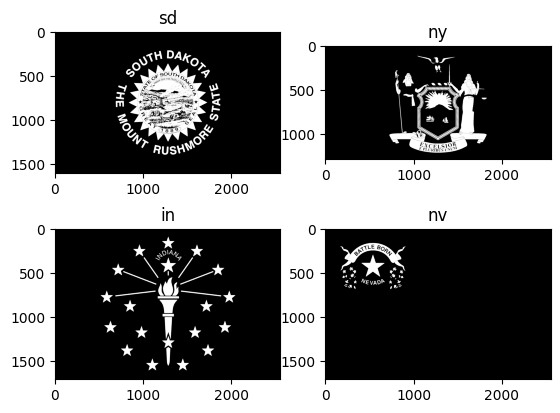

In [25]:
# Display four black-and-white flags in a 2x2 grid
'''ADD SOME CODE HERE'''
chosen_flags = []
for i0, i in enumerate(np.random.choice(range(50), 4, replace = False)):
    plt.subplot(2,2,1+i0)
    plt.imshow(flag_data[0][i],cmap='Greys_r')
    plt.title(flag_data[1][i])
    chosen_flags.append(i)

### Part 2.2: SVMs for flag pixel data
The function `sample_pixels` samples a pixel from a given image uniformly at random. 

1. Use the `sample_pixels`  function to generate synthetic data sets of pixels from for a flag image.
2. Update the `kernel_comparison` function so that if `if_flag` is `True` the decision boundaries are plotted in a 2x2 grid of subplots with plot ranges matching the height and width of the flags.
3. Show the results of the kernel comparison for the four flags that your previously selected. Use the highest values of `degree` and `gamma` that still run *reasonably fast* on your laptop.
4. Adjust your code so that you can run the quantitative part (i.e., the calculation of train and test accuracy) without plotting the decision boundaries. Run the adjusted code on all flags to indentify for each kernel the flags that yield to best easiest-to-classify and hardest-to-classify data sets. Test how the number of of pixels sampled affects your results.

In [26]:
def sample_pixels(image, num_samples=100):
    pixel_data = []
    pixel_labels = []
    height, width = image.shape
    for _ in range(num_samples):
        x1 = random.randint(0, width - 1)
        x2 = random.randint(0, height - 1)
        pixel_data.append([x1/width-0.5, x2/width-0.5])
        pixel_labels.append(image[x2,x1])
    return np.array(pixel_data), np.array(pixel_labels, dtype=int)

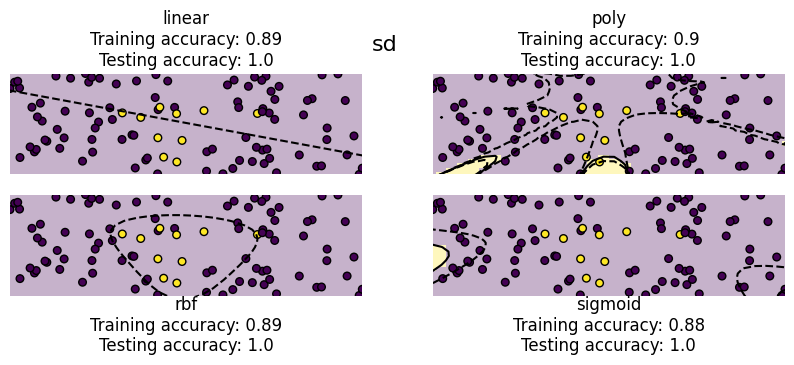

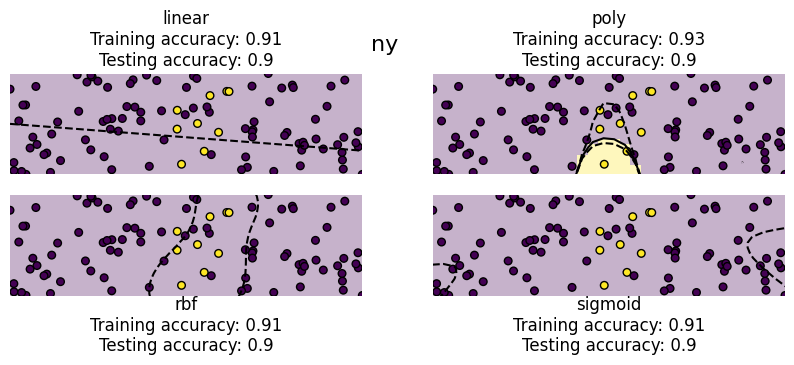

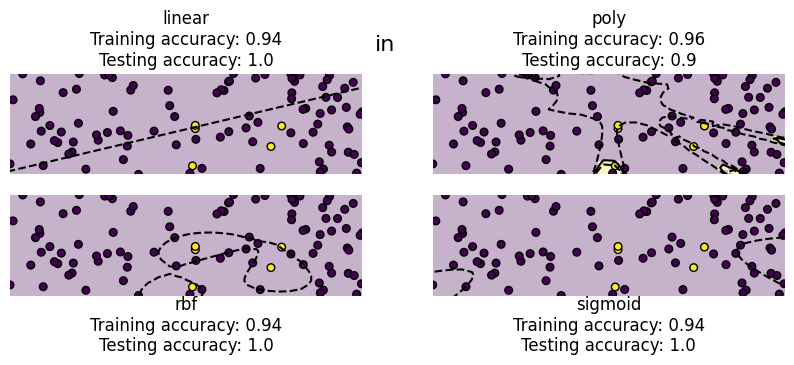

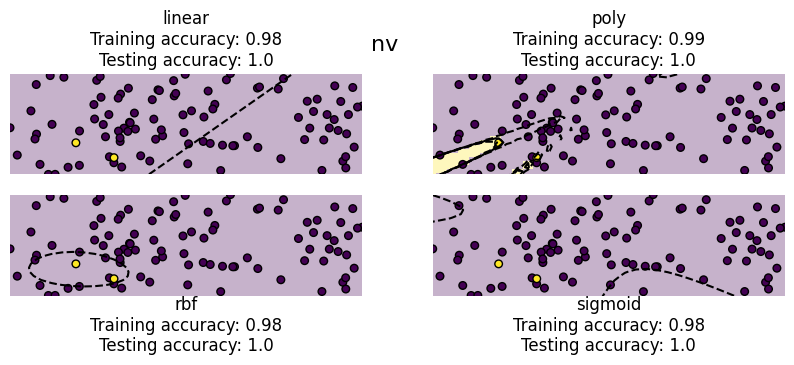

In [27]:
# Visual kernel comparison for selected flags
'''ADD SOME CODE HERE'''
for i in chosen_flags:
    current_flag = sample_pixels(flag_data[0][i], num_samples = 100)
    kernel_comparison(current_flag[0], current_flag[1],flag_data[1][i], degree = 10, gamma = 15,
                      if_flag = True, tight_box=True, support_vectors = False, accuracy = True)

In [40]:
# Non-visual kernel comparison for all flags
'''ADD SOME CODE HERE'''
flag_accuracies = {}
for i in range(len(flag_data[0])):
    current_flag = sample_pixels(flag_data[0][i])
    flag_accuracies[flag_data[1][i]] = kernel_comparison(current_flag[0], current_flag[1],flag_data[1][i], degree = 8, gamma = 15,
                      if_flag = True, tight_box=True, support_vectors = False, accuracy = True, visualize = False)

In [41]:
flattened_data = []
for dataset, models in flag_accuracies.items():
    for model, accuracies in models.items():
        training_acc, testing_acc = accuracies
        flattened_data.append((dataset, model, training_acc, testing_acc))

# Create a DataFrame from the flattened data
flag_df = pd.DataFrame(flattened_data, columns=['State', 'Model', 'Training Accuracy', 'Testing Accuracy'])

flag_df

State    Model  Training Accuracy  Testing Accuracy
0      ut   linear               0.94               0.9
1      ut     poly               0.94               0.9
2      ut      rbf               0.94               0.9
3      ut  sigmoid               0.94               0.9
4      me   linear               0.90               1.0
..    ...      ...                ...               ...
195    ct  sigmoid               0.64               0.8
196    nd   linear               0.98               0.7
197    nd     poly               0.98               0.7
198    nd      rbf               0.98               0.7
199    nd  sigmoid               0.98               0.7

[200 rows x 4 columns]

In [42]:
flag_model_means = flag_df[['Model', 'Training Accuracy', 'Testing Accuracy']].groupby('Model').mean()
flag_means = flag_df[['State', 'Training Accuracy', 'Testing Accuracy']].groupby('State').mean()

In [43]:
flag_model_means

Training Accuracy  Testing Accuracy
Model                                       
linear              0.8476             0.854
poly                0.8818             0.870
rbf                 0.8954             0.888
sigmoid             0.7842             0.798

In [44]:
flag_means.sort_values(by='Testing Accuracy', ascending=False)

Training Accuracy  Testing Accuracy
State                                     
ak                0.9800             1.000
tn                0.9800             1.000
ny                0.9300             1.000
or                0.9400             1.000
me                0.9000             1.000
ky                0.9100             1.000
nm                0.9600             1.000
id                0.9300             1.000
in                0.9600             1.000
de                0.9200             1.000
nv                0.9925             0.975
oh                0.7550             0.925
ks                0.8525             0.925
wa                0.8600             0.925
va                0.8800             0.900
wi                0.9050             0.900
ms                0.8775             0.900
ok                0.9075             0.900
mi                0.9300             0.900
sd                0.8350             0.900
pa                0.9250             0.900
sc                0.9250             0.900
la                0.9000             0.900
ut                0.9400             0.900
ct                0.7900             0.900
il                0.9300             0.900
ri                0.9900             0.900
ma                0.9100             0.900
mt                0.8200             0.875
ne                0.8400             0.850
ar                0.7850             0.850
nj                0.9050             0.800
az                0.7450             0.800
vt                0.9400             0.800
mo                0.7625             0.800
co                0.7275             0.800
tx                0.8425             0.800
nh                0.8125             0.775
wy                0.8100             0.775
ga                0.7950             0.750
wv                0.6475             0.750
nc                0.8050             0.725
ia                0.7175             0.700
ca                0.7575             0.700
nd                0.9800             0.700
al                0.6675             0.675
mn                0.8525             0.650
hi                0.6225             0.625
md                0.5975             0.550
fl                0.6650             0.525

In [45]:
def display_flag(data, flag):
    plt.imshow(data[0][data[1].index(flag)],cmap='Greys_r')
    plt.title(data[1][data[1].index(flag)])
    plt.show()

Based on the final accuracies, we found that the best states for classification were Alaska, Nevada, and Kentucky. But, this is not because the classification was best for these states. It is because the colors of these flags was predominantly one color, so the model could just create the boundary so that all of the points are one color and still achieve high accuracy.

For instance, if we look at Alaska's flag and boundaries in the cell below:

We see that all of the models yielded high accuracy, but only because the entire flag was classified as black and there weren't many white dots to be misclassified.

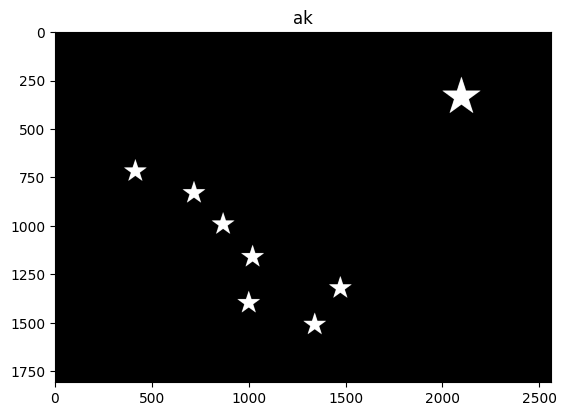

{'linear': (0.99, 1.0),
 'poly': (0.99, 1.0),
 'rbf': (0.99, 1.0),
 'sigmoid': (0.99, 1.0)}

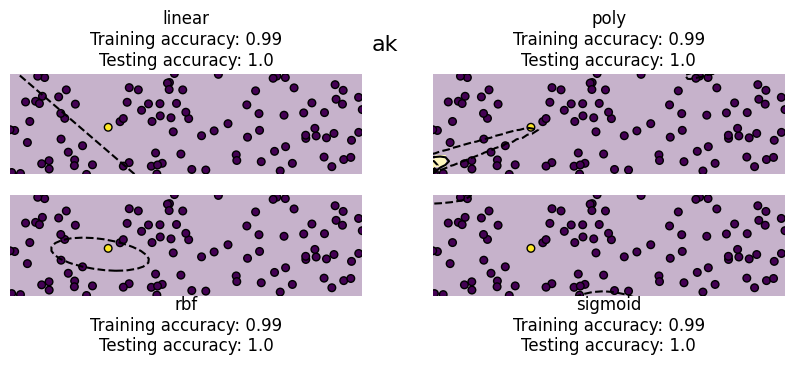

In [48]:
display_flag(flag_data, "ak")
current_flag = sample_pixels(flag_data[0][flag_data[1].index("ak")])
kernel_comparison(current_flag[0], current_flag[1],"ak", degree = 10, gamma = 15,
                      if_flag = True, tight_box=True, support_vectors = False, accuracy = True)

On the other hand, we can examine Alabama which had among the worst training and testing accuracy:

We find that even though the flag is very simple and should be relatively easy to classify, especially for the rbf, we get a poor score which is highly volatile and changes very frequently from trial to trial.

This is due to the fact that Alabama's flag isn't almost completely one color like Alaska's, so the boundary conditions actually attempted to classify the data, but still struggled, leading to a low accuracy.

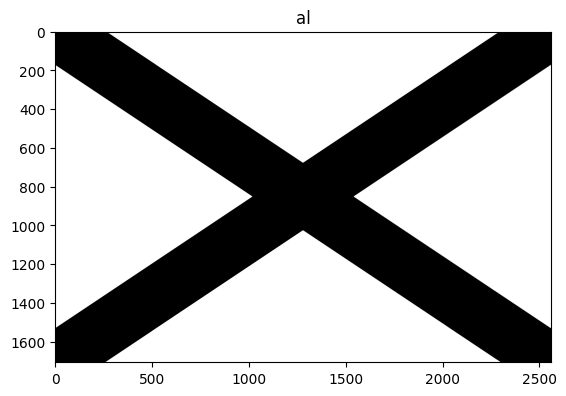

{'linear': (0.64, 0.5),
 'poly': (0.83, 0.7),
 'rbf': (0.79, 0.6),
 'sigmoid': (0.52, 0.5)}

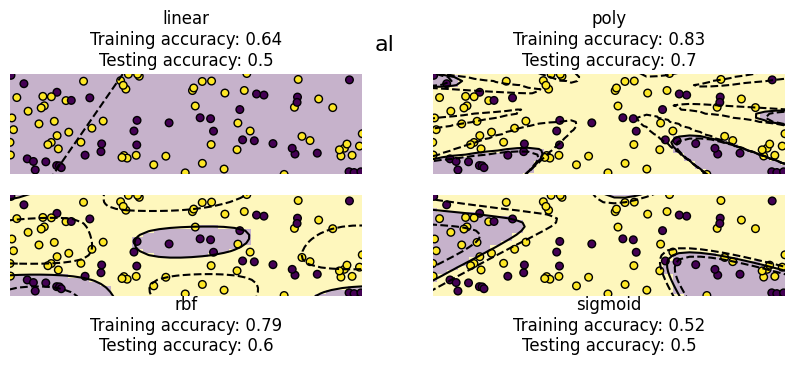

In [49]:
display_flag(flag_data, "al")
current_flag = sample_pixels(flag_data[0][flag_data[1].index("al")])
kernel_comparison(current_flag[0], current_flag[1],"al", degree = 10, gamma = 15,
                      if_flag = True, tight_box=True, support_vectors = False, accuracy = True)

This issue of models not being punished for just classifying the entire flag as one color is largely a result of the low number of samples generated from the flag. Flags with majority one color are likely to sample mostly one color and so the model does not misclassify as frequently.

We can counteract this by increasing the number of sampled pixels tenfold to increase the likelihood of a mixed color sample and to better represent the flags.

In [50]:
flag_accuracies = {}
for i in range(len(flag_data[0])):
    current_flag = sample_pixels(flag_data[0][i], num_samples = 1000)
    flag_accuracies[flag_data[1][i]] = kernel_comparison(current_flag[0], current_flag[1],flag_data[1][i], degree = 8, gamma = 15,
                      if_flag = True, tight_box=True, support_vectors = False, accuracy = True, visualize = False)

In [51]:
flattened_data = []
for dataset, models in flag_accuracies.items():
    for model, accuracies in models.items():
        training_acc, testing_acc = accuracies
        flattened_data.append((dataset, model, training_acc, testing_acc))

# Create a DataFrame from the flattened data
flag_df = pd.DataFrame(flattened_data, columns=['State', 'Model', 'Training Accuracy', 'Testing Accuracy'])

flag_df

State    Model  Training Accuracy  Testing Accuracy
0      ut   linear               0.92              0.92
1      ut     poly               0.92              0.92
2      ut      rbf               0.92              0.92
3      ut  sigmoid               0.85              0.88
4      me   linear               0.95              0.98
..    ...      ...                ...               ...
195    ct  sigmoid               0.58              0.52
196    nd   linear               0.92              0.93
197    nd     poly               0.92              0.93
198    nd      rbf               0.92              0.93
199    nd  sigmoid               0.86              0.89

[200 rows x 4 columns]

In [52]:
flag_model_means = flag_df[['Model', 'Training Accuracy', 'Testing Accuracy']].groupby('Model').mean()
flag_means = flag_df[['State', 'Training Accuracy', 'Testing Accuracy']].groupby('State').mean()

In [53]:
flag_model_means

Training Accuracy  Testing Accuracy
Model                                       
linear              0.8470            0.8462
poly                0.8666            0.8608
rbf                 0.9078            0.9000
sigmoid             0.7390            0.7404

In [54]:
flag_means.sort_values(by='Testing Accuracy', ascending=False)

Training Accuracy  Testing Accuracy
State                                     
ak                0.9900            1.0000
nv                0.9800            0.9875
ri                0.9800            0.9800
me                0.9425            0.9775
de                0.9400            0.9500
in                0.9325            0.9400
nj                0.8950            0.9325
nm                0.9275            0.9275
nd                0.9050            0.9200
ny                0.8800            0.9150
ks                0.9025            0.9125
tn                0.9200            0.9100
vt                0.9375            0.9100
ut                0.9025            0.9100
pa                0.9425            0.9075
ma                0.9225            0.8975
id                0.9200            0.8950
ky                0.9100            0.8900
wi                0.8750            0.8875
ne                0.8625            0.8775
ms                0.8550            0.8750
mi                0.8650            0.8725
or                0.8900            0.8700
sc                0.8900            0.8650
ok                0.8875            0.8550
wa                0.8400            0.8525
nh                0.8650            0.8450
tx                0.8450            0.8450
il                0.9025            0.8350
ar                0.8125            0.8325
sd                0.8650            0.8275
mn                0.8100            0.8100
la                0.8075            0.8100
az                0.7925            0.7975
ga                0.7900            0.7950
va                0.8100            0.7925
nc                0.7650            0.7700
oh                0.7500            0.7675
wy                0.7700            0.7500
ct                0.7775            0.7450
mt                0.8000            0.7425
co                0.7400            0.7350
mo                0.7350            0.7125
hi                0.6275            0.7125
ca                0.7425            0.7050
ia                0.6775            0.7000
al                0.6925            0.6975
fl                0.6775            0.6925
wv                0.6775            0.6675
md                0.5775            0.5375

We can see that once again, Alaska was the highest accuracy (by the same 1 color majority seen before), but many of the accuracies did improve with more samples. For instance, Alabama's testing accuracy increased from 0.425 to 0.665.

In [55]:
flag_df[flag_df['Model'] == 'linear'].sort_values(by='Testing Accuracy', ascending=False)

State   Model  Training Accuracy  Testing Accuracy
188    ak  linear               0.99              1.00
128    nv  linear               0.98              0.99
120    ri  linear               0.98              0.98
4      me  linear               0.95              0.98
108    de  linear               0.95              0.96
64     nm  linear               0.94              0.95
28     nj  linear               0.91              0.95
68     in  linear               0.94              0.95
48     ny  linear               0.90              0.94
196    nd  linear               0.92              0.93
176    vt  linear               0.95              0.92
124    tn  linear               0.93              0.92
80     ks  linear               0.92              0.92
0      ut  linear               0.92              0.92
36     wi  linear               0.90              0.92
116    pa  linear               0.95              0.91
100    id  linear               0.93              0.90
184    ne  linear               0.88              0.90
60     ma  linear               0.93              0.90
20     ms  linear               0.88              0.90
96     ky  linear               0.92              0.90
180    mi  linear               0.89              0.89
136    tx  linear               0.89              0.89
132    or  linear               0.91              0.89
40     ok  linear               0.91              0.88
140    wa  linear               0.85              0.87
16     nh  linear               0.89              0.87
72     sc  linear               0.90              0.87
32     ar  linear               0.82              0.85
92     sd  linear               0.88              0.85
84     il  linear               0.92              0.85
8      la  linear               0.83              0.83
164    mn  linear               0.83              0.83
148    nc  linear               0.83              0.82
172    va  linear               0.83              0.82
160    az  linear               0.79              0.79
56     oh  linear               0.78              0.79
88     ga  linear               0.78              0.79
52     wy  linear               0.80              0.78
192    ct  linear               0.78              0.78
168    ca  linear               0.82              0.76
44     mt  linear               0.82              0.75
76     hi  linear               0.60              0.73
12     co  linear               0.74              0.72
156    al  linear               0.63              0.68
152    mo  linear               0.73              0.68
112    fl  linear               0.62              0.66
144    wv  linear               0.64              0.64
104    ia  linear               0.56              0.61
24     md  linear               0.51              0.50

For these experiments, I set `num_samples` to 1000 because the results of the experiments seem to be the most stable for this number of sampled pixels.

The linear kernel performed best (i.e., highest test accuracy) on the flags of the following three states: 

Alaksa, Rhode Island, Nevada

It performed worst on the flags of the following three states: 

Florida, Iowa, Maryland

In [56]:
flag_df[flag_df['Model'] == 'poly'].sort_values(by='Testing Accuracy', ascending=False)

State Model  Training Accuracy  Testing Accuracy
189    ak  poly               0.99              1.00
129    nv  poly               0.98              0.99
121    ri  poly               0.98              0.98
5      me  poly               0.95              0.98
109    de  poly               0.95              0.96
65     nm  poly               0.94              0.95
29     nj  poly               0.91              0.95
69     in  poly               0.94              0.95
49     ny  poly               0.90              0.94
197    nd  poly               0.92              0.93
137    tx  poly               0.94              0.93
177    vt  poly               0.95              0.92
125    tn  poly               0.93              0.92
105    ia  poly               0.92              0.92
81     ks  poly               0.92              0.92
1      ut  poly               0.92              0.92
37     wi  poly               0.90              0.92
117    pa  poly               0.95              0.91
61     ma  poly               0.93              0.90
97     ky  poly               0.92              0.90
185    ne  poly               0.88              0.90
21     ms  poly               0.88              0.90
101    id  poly               0.93              0.90
133    or  poly               0.91              0.89
181    mi  poly               0.89              0.89
41     ok  poly               0.91              0.88
17     nh  poly               0.89              0.87
9      la  poly               0.86              0.87
73     sc  poly               0.90              0.87
141    wa  poly               0.85              0.87
161    az  poly               0.82              0.86
93     sd  poly               0.88              0.85
33     ar  poly               0.82              0.85
85     il  poly               0.92              0.85
165    mn  poly               0.83              0.83
193    ct  poly               0.87              0.82
173    va  poly               0.83              0.82
57     oh  poly               0.78              0.79
77     hi  poly               0.67              0.79
89     ga  poly               0.81              0.79
53     wy  poly               0.80              0.78
149    nc  poly               0.76              0.75
45     mt  poly               0.82              0.75
145    wv  poly               0.77              0.75
153    mo  poly               0.78              0.73
13     co  poly               0.76              0.73
113    fl  poly               0.71              0.72
157    al  poly               0.71              0.71
169    ca  poly               0.74              0.67
25     md  poly               0.61              0.57

The polynomial kernel performed best on the flags of the following three states: 

Alaksa, Rhode Island, Nevada

It performed worst on the flags of the following three states: 

Hawaii, Alabama, Maryland

In [57]:
flag_df[flag_df['Model'] == 'rbf'].sort_values(by='Testing Accuracy', ascending=False)

State Model  Training Accuracy  Testing Accuracy
190    ak   rbf               0.99              1.00
130    nv   rbf               0.98              0.99
6      me   rbf               0.95              0.98
122    ri   rbf               0.98              0.98
150    nc   rbf               0.93              0.97
138    tx   rbf               0.97              0.96
110    de   rbf               0.95              0.96
98     ky   rbf               0.96              0.96
34     ar   rbf               0.95              0.95
90     ga   rbf               0.96              0.95
66     nm   rbf               0.94              0.95
70     in   rbf               0.94              0.95
30     nj   rbf               0.93              0.94
154    mo   rbf               0.92              0.94
50     ny   rbf               0.90              0.94
14     co   rbf               0.94              0.94
62     ma   rbf               0.97              0.94
166    mn   rbf               0.92              0.93
102    id   rbf               0.95              0.93
198    nd   rbf               0.92              0.93
82     ks   rbf               0.92              0.92
46     mt   rbf               0.90              0.92
186    ne   rbf               0.92              0.92
178    vt   rbf               0.95              0.92
38     wi   rbf               0.90              0.92
126    tn   rbf               0.93              0.92
2      ut   rbf               0.92              0.92
74     sc   rbf               0.93              0.92
118    pa   rbf               0.95              0.91
22     ms   rbf               0.88              0.90
174    va   rbf               0.92              0.90
142    wa   rbf               0.94              0.90
134    or   rbf               0.91              0.89
182    mi   rbf               0.89              0.89
94     sd   rbf               0.92              0.89
42     ok   rbf               0.91              0.88
86     il   rbf               0.92              0.88
18     nh   rbf               0.89              0.87
58     oh   rbf               0.81              0.87
106    ia   rbf               0.91              0.86
10     la   rbf               0.87              0.86
194    ct   rbf               0.88              0.86
114    fl   rbf               0.89              0.84
158    al   rbf               0.89              0.84
54     wy   rbf               0.81              0.84
146    wv   rbf               0.82              0.79
78     hi   rbf               0.67              0.79
170    ca   rbf               0.86              0.78
162    az   rbf               0.83              0.73
26     md   rbf               0.70              0.58

The radial-basis function kernel performed best on the flags of the following three states: 

Alaska, Rhode Island, Georgia

It performed worst on the flags of the following three states: 

Arizona, Hawaii, Maryland

In [58]:
flag_df[flag_df['Model'] == 'sigmoid'].sort_values(by='Testing Accuracy', ascending=False)

State    Model  Training Accuracy  Testing Accuracy
191    ak  sigmoid               0.99              1.00
131    nv  sigmoid               0.98              0.98
123    ri  sigmoid               0.98              0.98
7      me  sigmoid               0.92              0.97
111    de  sigmoid               0.91              0.92
71     in  sigmoid               0.91              0.91
119    pa  sigmoid               0.92              0.90
199    nd  sigmoid               0.86              0.89
31     nj  sigmoid               0.83              0.89
83     ks  sigmoid               0.85              0.89
179    vt  sigmoid               0.90              0.88
127    tn  sigmoid               0.89              0.88
3      ut  sigmoid               0.85              0.88
67     nm  sigmoid               0.89              0.86
103    id  sigmoid               0.87              0.85
63     ma  sigmoid               0.86              0.85
51     ny  sigmoid               0.82              0.84
183    mi  sigmoid               0.79              0.82
163    az  sigmoid               0.73              0.81
135    or  sigmoid               0.83              0.81
99     ky  sigmoid               0.84              0.80
23     ms  sigmoid               0.78              0.80
75     sc  sigmoid               0.83              0.80
39     wi  sigmoid               0.80              0.79
187    ne  sigmoid               0.77              0.79
43     ok  sigmoid               0.82              0.78
19     nh  sigmoid               0.79              0.77
143    wa  sigmoid               0.72              0.77
87     il  sigmoid               0.85              0.76
95     sd  sigmoid               0.78              0.72
11     la  sigmoid               0.67              0.68
35     ar  sigmoid               0.66              0.68
91     ga  sigmoid               0.61              0.65
167    mn  sigmoid               0.66              0.65
175    va  sigmoid               0.66              0.63
59     oh  sigmoid               0.63              0.62
171    ca  sigmoid               0.55              0.61
55     wy  sigmoid               0.67              0.60
139    tx  sigmoid               0.58              0.60
159    al  sigmoid               0.54              0.56
47     mt  sigmoid               0.66              0.55
15     co  sigmoid               0.52              0.55
115    fl  sigmoid               0.49              0.55
79     hi  sigmoid               0.57              0.54
151    nc  sigmoid               0.54              0.54
195    ct  sigmoid               0.58              0.52
155    mo  sigmoid               0.51              0.50
27     md  sigmoid               0.49              0.50
147    wv  sigmoid               0.48              0.49
107    ia  sigmoid               0.32              0.41

The sigmoid kernel performed best on the flags of the following three states: 

Alaska, Rhode Island, Nevada

It performed worst on the flags of the following three states:

Alabama, Maryland, Iowa

### Part 2.3: Comparison to decision trees
Decision trees and SVMs yield substantially different decision boundaries.

1. An arbitrarily complex decision tree would be able to achieve perfect training accuracy on any data set. Explain why.
2. For a very large data set of flag pixels, an arbitrarily complex decision tree is likely to achieve (almost) perfect test accuracy as well. Explain why.
3. Select four flags for which you anticipate a *simple* decision tree to outperform all your SVMs. Write code that fits a decision tree to a flag pixel data set. Use your code to check your hypothesis. 

An arbitrarily complex decision tree would be able to achieve perfect training accuracy on any data set, because it could draw a rule to capture every single data point. For example, assuming every training sample was unique, it could make a rule for every single data point that just says, if the parameters = the training sample, then output = training result.

For a very large data set of flag pixels, an arbitrarily complex decision tree is likely to achieve (almost) perfect test accuracy because with an extremely large sample size, the training pool will be extremely representative of the testing pool. This isn't necessarily a bad thing, it is basically overfitting on the training set, but the training set is highly representative of the testing set.

A simple decision tree is likely to perform well on the sampled pixel data of the flags of Texas, New Mexico, Rhode Island, Alabama, and Florida.

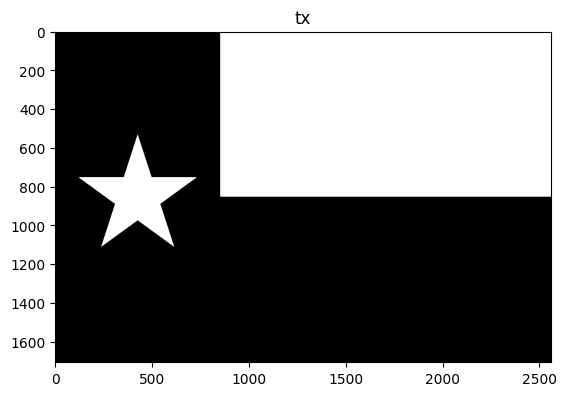

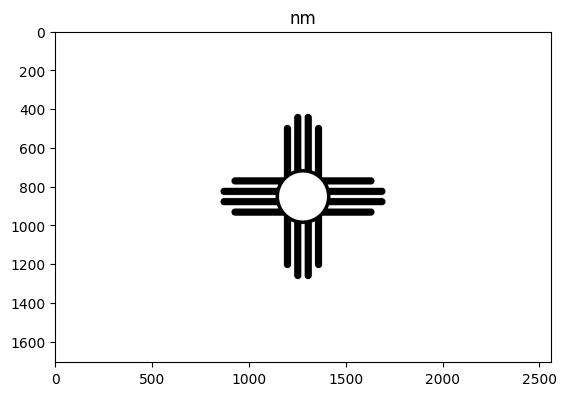

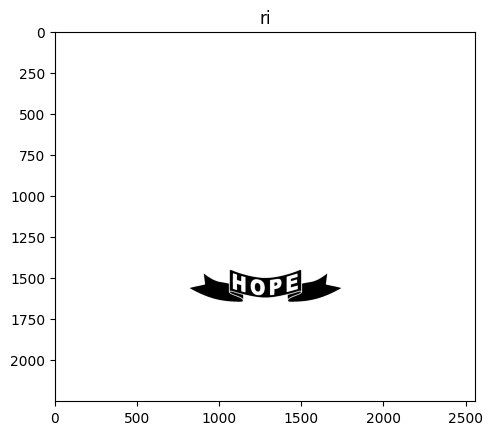

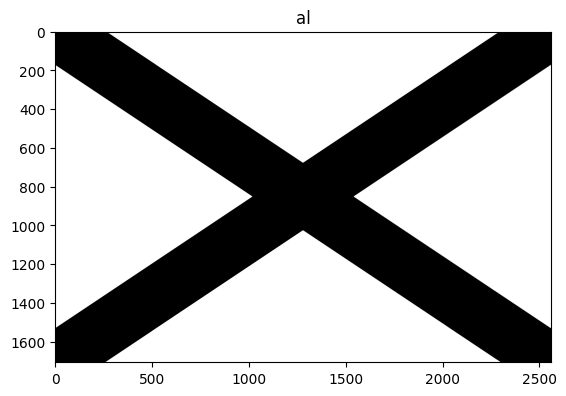

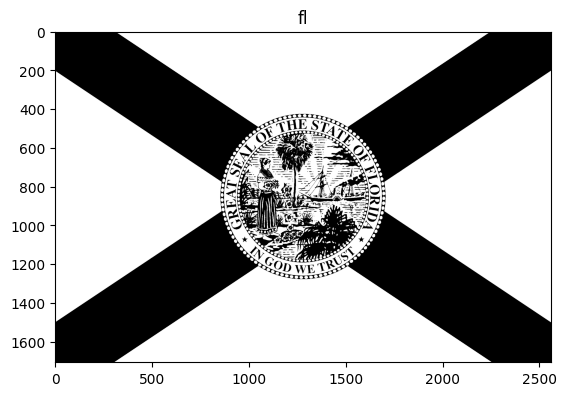

In [59]:
easy_states = ["tx", "nm", "ri", "al", "fl"]
for i in easy_states:
    display_flag(flag_data, i)

In [60]:
# Comparison of SVM and decision tree performance on sampled pixel data for four flags

'''ADD CODE HERE'''
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_leaf_nodes = 10)
    
# Fit model to training data

for i in easy_states:
    current_flag = sample_pixels(flag_data[0][flag_data[1].index(i)], num_samples = 10000)
    X_train, X_test, y_train, y_test = train_test_split(current_flag[0], current_flag[1], test_size=0.1, random_state = 42)
    dtc.fit(X_train, y_train)
    print("{}| training accuracy: {}| testing accuracy: {}".format(i, round(dtc.score(X_train, y_train),2), round(dtc.score(X_test, y_test),2)))

tx| training accuracy: 0.99| testing accuracy: 0.99
nm| training accuracy: 0.97| testing accuracy: 0.97
ri| training accuracy: 0.99| testing accuracy: 0.99
al| training accuracy: 0.65| testing accuracy: 0.67
fl| training accuracy: 0.69| testing accuracy: 0.68
